# Local Mode
The local mode in executorlib which is selected by setting the `backend` parameter to `"local"` is primarily used to enable rapid prototyping on a workstation computer to test your parallel Python program with executorlib before transferring it to an high performance computer (HPC). With the added capability of executorlib it is typically 10% slower than the [ProcessPoolExecutor](https://docs.python.org/3/library/concurrent.futures.html#processpoolexecutor) from the Python standard library on a single node, when all acceleration features are enabled. This overhead is primarily related to the creation of new tasks. So the performance of executorlib improves when the individual Python function calls require extensive computations. 

On advantage that executorlib has over the [ProcessPoolExecutor](https://docs.python.org/3/library/concurrent.futures.html#processpoolexecutor) and the [ThreadPoolExecutor](https://docs.python.org/3/library/concurrent.futures.html#threadpoolexecutor) from the Python standard libary, is the use of [cloudpickle](https://github.com/cloudpipe/cloudpickle) as serialization backend to transfer Python functions between processes. This enables the use of dynamically defined Python functions for example in the case of a Jupyter notebook. 

## Basic Functionality
The general functionality of executorlib follows the [Executor interface](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.Executor) of the Python standard library. You can import the `Executor` class directly from executorlib and then just replace the [ProcessPoolExecutor](https://docs.python.org/3/library/concurrent.futures.html#processpoolexecutor) or [ThreadPoolExecutor](https://docs.python.org/3/library/concurrent.futures.html#threadpoolexecutor) with the `Executor` class to start using executorlib. 

In [1]:
from executorlib import Executor

It is recommended to use the `Executor` class in combination with a `with`-statement. This gurantees the processes created by the `Executor` class to evaluate the Python functions are afterward closed and do not remain ghost processes. A function is then submitted using the `submit(fn, /, *args, **kwargs)` function which executes a given function `fn` as `fn(*args, **kwargs)`. The `submit()` function returns a [concurrent.futures.Future](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.Future) object, as defined by the Python Standard Library. As a first example we submit the function `sum()` to calculate the sum of the list `[1, 1]`:

In [2]:
%%time
with Executor() as exe:
    future = exe.submit(sum, [1, 1])
    print(future.result())

2
CPU times: user 19.9 ms, sys: 14.6 ms, total: 34.5 ms
Wall time: 210 ms


As expected the result of the summation `sum([1, 1])` is `2`. The same result is retrieved from the [concurrent.futures.Future](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.Future) object received from the submission of the `sum()` as it is printed here `print(future.result())`. For most Python functions and especially the `sum()` function it is computationally not efficient to initialize the `Executor` class only for the execution of a single function call, rather it is more computationally efficient to initialize the `Executor` class once and then submit a number of functions. This can be achieved with a loop. For example the sum of the pairs `[2, 2]`, `[3, 3]` and `[4, 4]` can be achieved with a for-loop inside the context of the `Executor()` class as provided by the `with`-statement. 

In [3]:
%%time
with Executor() as exe:
    future_lst = [exe.submit(sum, [i, i]) for i in range(2, 5)]
    print([f.result() for f in future_lst])

[4, 6, 8]
CPU times: user 7.72 ms, sys: 7.54 ms, total: 15.3 ms
Wall time: 187 ms


If only the parameters change but the function, which is applied to these parameters, remains the same, like in the case above the `sum()` function is applied to three pairs of parameters, then the `map(fn, *iterables, timeout=None, chunksize=1)` function can be used to map the function to the different sets of parameters - as it is defined in the [Python standard library](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.Executor.map). 

In [4]:
%%time
with Executor() as exe:
    results = exe.map(sum, [[5, 5], [6, 6], [7, 7]])
    print(list(results))

[10, 12, 14]
CPU times: user 7.16 ms, sys: 7.72 ms, total: 14.9 ms
Wall time: 191 ms


These three examples cover the general functionality of the `Executor` class. Following the [Executor](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.Executor) interface as it is defined in the Python standard library. 

## Parallel Functions
Writing parallel software is not trivial. So rather than writing the whole Python program in a parallel way, executorlib allows developers to implement parallel execution on a function by function level. In this way individual functions can be replaced by parallel functions as needed without the need to modify the rest of the program. With the Local Mode executorlib supports two levels of parallel execution, parallel execution based on the Message Passing Interface (MPI) using the [mpi4py](https://mpi4py.readthedocs.io) package, or thread based parallel execution. Both levels of parallelism can be defined inside the function and do not require any modifications to the rest of the Python program. 

### MPI Parallel Functions
MPI is the default way to develop parallel programs for HPCs. Still it can be challenging to refactor a previously serial program to efficiently use MPI to achieve optimal computational efficiency for parallel execution, even with libraries like [mpi4py](https://mpi4py.readthedocs.io). To simplify the up-scaling of Python programs executorlib provides the option to use MPI parallel Python code inside a given Python function and then submit this parallel Python function to an `Executor` for evaluation. 

The following `calc_mpi()` function imports the [mpi4py](https://mpi4py.readthedocs.io) package and then uses the internal functionality of MPI to get the total number of parallel CPU cores in the current MPI group `MPI.COMM_WORLD.Get_size()` and the index of the current processor in the MPI group `MPI.COMM_WORLD.Get_rank()`.

In [5]:
def calc_mpi(i):
    from mpi4py import MPI

    size = MPI.COMM_WORLD.Get_size()
    rank = MPI.COMM_WORLD.Get_rank()
    return i, size, rank

In [6]:
with Executor(backend="local") as exe:
    fs = exe.submit(calc_mpi, 3, resource_dict={"cores": 2})
    print(fs.result())

[(3, 2, 0), (3, 2, 1)]


In [7]:
with Executor(resource_dict={"cores": 2}, backend="local") as exe:
    fs = exe.submit(calc_mpi, 3)
    print(fs.result())

[(3, 2, 0), (3, 2, 1)]


### Thread Parallel Functions

In [8]:
def calc_with_threads(i):
    import os

    os.environ["OMP_NUM_THREADS"] = "2"
    os.environ["OPENBLAS_NUM_THREADS"] = "2"
    os.environ["MKL_NUM_THREADS"] = "2"
    os.environ["VECLIB_MAXIMUM_THREADS"] = "2"
    os.environ["NUMEXPR_NUM_THREADS"] = "2"
    import numpy as np

    return i

In [9]:
with Executor(backend="local") as exe:
    fs = exe.submit(calc_with_threads, 3, resource_dict={"threads_per_core": 2})
    print(fs.result())

3


In [10]:
with Executor(backend="local", resource_dict={"threads_per_core": 2}) as exe:
    fs = exe.submit(calc_with_threads, 3)
    print(fs.result())

3


## Performance Optimization

### Block Allocation

In [11]:
from executorlib import Executor

In [12]:
%%time
with Executor(backend="local", block_allocation=True) as exe:
    future = exe.submit(sum, [1, 1])
    print(future.result())

2
CPU times: user 12.2 ms, sys: 27.3 ms, total: 39.5 ms
Wall time: 280 ms


In [13]:
%%time
with Executor(backend="local", block_allocation=True) as exe:
    future_lst = [exe.submit(sum, [i, i]) for i in range(2, 5)]
    print([f.result() for f in future_lst])

[4, 6, 8]
CPU times: user 11.7 ms, sys: 28.1 ms, total: 39.8 ms
Wall time: 288 ms


In [14]:
%%time
with Executor(backend="local", block_allocation=True) as exe:
    results = exe.map(sum, [[5, 5], [6, 6], [7, 7]])
    print(list(results))

[10, 12, 14]
CPU times: user 11.6 ms, sys: 26.2 ms, total: 37.8 ms
Wall time: 268 ms


In [15]:
def calc(i):
    from mpi4py import MPI

    size = MPI.COMM_WORLD.Get_size()
    rank = MPI.COMM_WORLD.Get_rank()
    return i, size, rank

In [16]:
with Executor(
    max_workers=1,
    max_cores=2,
    resource_dict={"cores": 2},
    backend="local",
    block_allocation=True,
) as exe:
    fs = exe.submit(
        calc,
        3,
    )
    print(fs.result())

[(3, 2, 0), (3, 2, 1)]


In [17]:
def calc(i, j, k):
    return i + j + k

In [18]:
def init_function():
    return {"j": 4, "k": 3, "l": 2}

In [19]:
with Executor(
    init_function=init_function, backend="local", block_allocation=True
) as exe:
    fs = exe.submit(calc, 2, j=5)
    print(fs.result())

10


### Cache 

In [20]:
from executorlib import Executor

In [21]:
%%time
with Executor(backend="local", cache_directory="./cache") as exe:
    future_lst = [exe.submit(sum, [i, i]) for i in range(1, 4)]
    print([f.result() for f in future_lst])

[2, 4, 6]
CPU times: user 159 ms, sys: 50.1 ms, total: 209 ms
Wall time: 521 ms


In [22]:
%%time
with Executor(backend="local", cache_directory="./cache") as exe:
    future_lst = [exe.submit(sum, [i, i]) for i in range(1, 4)]
    print([f.result() for f in future_lst])

[2, 4, 6]
CPU times: user 10.8 ms, sys: 10.6 ms, total: 21.4 ms
Wall time: 188 ms


In [23]:
import os
import shutil

cache_dir = "./cache"
if os.path.exists(cache_dir):
    print(os.listdir(cache_dir))
    try:
        shutil.rmtree(cache_dir)
    except OSError:
        pass

['sumb6a5053f96b7031239c2e8d0e7563ce4.h5out', 'sum5171356dfe527405c606081cfbd2dffe.h5out', 'sumd1bf4ee658f1ac42924a2e4690e797f4.h5out']


### Dependencies

In [24]:
from executorlib import Executor

In [25]:
def add_funct(a, b):
    return a + b

In [26]:
with Executor(backend="local") as exe:
    future = None
    for i in range(1, 4):
        if future is None:
            future = exe.submit(add_funct, i, i)
        else:
            future = exe.submit(add_funct, i, future)
    print(future.result())

7


None


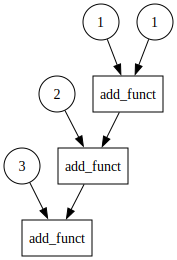

In [27]:
with Executor(backend="local", plot_dependency_graph=True) as exe:
    future = None
    for i in range(1, 4):
        if future is None:
            future = exe.submit(add_funct, i, i)
        else:
            future = exe.submit(add_funct, i, future)
    print(future.result())